# Does it matter if we calculate oma from individual days or from the monthly mean?


In [33]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [34]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [35]:
from __future__ import print_function
from numpy import *
from scipy import *
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
import scipy as sp


import seawater
import datetime as dt
""
from salishsea_tools import (
    nc_tools,
    viz_tools,
    geo_tools,
    tidetools
)

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.patches as patches
plt.style.use('seaborn-whitegrid')
import netCDF4 as nc

import cmocean as cm
import glob
import sys
sys.path.append('/data/tjarniko/mocsy')
sys.path.append('/data/tjarniko/MEOPAR/at3/notebooks/carbon_dev/CCCmaDEV/CCCma_src')
import mocsy
import CCCma
import CCCma_stations as cs
from matplotlib import reload
import arrow
import gsw
%matplotlib inline

/home/tjarniko/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1357: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [36]:


def mocsy_2d_perturb(carp,grid, depth_ind, perturb):
    
    #retrieve relevant data for mocsy calculation, calculate mocsy
    tsal = grid.variables['vosaline'][0,depth_ind,:,:]
    ttemp = grid.variables['votemper'][0,depth_ind,:,:]
    tdic = carp.variables['dissolved_inorganic_carbon'][0,depth_ind,:,:]-perturb
    tta = carp.variables['total_alkalinity'][0,depth_ind,:,:]

    tsra = np.ravel(tsal)
    ttera = np.ravel(ttemp)
    ttara = np.ravel(tta) * 1e-3
    tdra = np.ravel(tdic) * 1e-3
    tzero = np.zeros_like(tsra)
    tpressure = np.zeros_like(tsra)
    tpressure[:] =1
    tzero = tpressure * 0 
        
    tsra_psu = tsra*35/35.16504
    ttera_is = gsw.t_from_CT(tsra,ttera,tzero)

    response_tup = mocsy.mvars(temp=ttera_is, sal=tsra_psu, alk=ttara, dic=tdra, 
                       sil=tzero, phos=tzero, patm=tpressure, depth=tzero, lat=tzero, 
                        optcon='mol/m3', optt='Tinsitu', optp='m',
                        optb = 'l10', optk1k2='m10', optkf = 'dg', optgas = 'Pinsitu')
    pH,pco2,fco2,co2,hco3,co3,OmegaA,OmegaC,BetaD,DENis,p,Tis = response_tup


    OmegaAR = OmegaA.reshape(898,398)
    return OmegaAR

In [37]:
#test april, december
#montly plot
mon = 'apr'
plotstr_carp = f'/data/tjarniko/results/BASERUN_EXP/MAIN/BR_2nd_2015/MONTHLY/SKOG_1m_2015{mon}_2015{mon}_carp_T.nc'
plotstr_grid = f'/data/tjarniko/results/BASERUN_EXP/MAIN/BR_2nd_2015/MONTHLY/SKOG_1m_2015{mon}_2015{mon}_grid_T.nc'

tcarp = nc.Dataset(plotstr_carp)
tgrid = nc.Dataset(plotstr_grid)


OmegaAR_apr_avg = mocsy_2d_perturb(tcarp,tgrid, 0, 0)


In [38]:
#where to start
#sdir_2 = '/data/tjarniko/results/BASERUN_EXP/MAIN/BR_2nd_2015/ncs/
start1 = '2015-04-01'
end1 = '2015-04-30'
# st = dt.datetime(2015,1,1)
# en = dt.datetime(2015,12,31)

sdir_1 = '/data/tjarniko/results/BASERUN_EXP/MAIN/BR_2nd_2015/ncs'

def make_nclen(start,end,ftype, sdir):
    base_ar = []
    sens_ar = []
    start_run = arrow.get(start)
    end_run = arrow.get(end)
    arrow_array = []
    for r in arrow.Arrow.span_range('day', start_run, end_run):
        arrow_array.append(r)
    dayslen = len(arrow_array)

    for i in range(0,dayslen):
        tdate = arrow_array[i][0]
        ddmmmyy = tdate.format('DDMMMYY').lower()
        ymd = tdate.format('YYYYMMDD')
        nc_sens = sdir + '/SKOG_1d_*'+ ftype +'_T_' + ymd + '-' + ymd + '.nc'
        tnc_sens = glob.glob(nc_sens)
        #print(tnc_sens[0])
        sens_ar.append(tnc_sens[0])
        
    return sens_ar

sens_ar_1st = make_nclen(start1,end1,'carp', sdir_1)
sens_ar_1st_grid = make_nclen(start1,end1,'grid', sdir_1)




In [39]:
OmAR_array = np.zeros([30,898,398])

for i in range(0,30):
    if i%5 == 0:
        print(i)
    carpstr = sens_ar_1st[i]
    gridstr = sens_ar_1st_grid[i]
    
    tcarp = nc.Dataset(carpstr)
    tgrid = nc.Dataset(gridstr)
    OmAR_array[i,:,:] = mocsy_2d_perturb(tcarp,tgrid, 0, 0)

0
5
10
15
20
25


In [40]:
OmAR_meancalc = OmegaAR_apr_avg
OmAR_indivcalc = np.mean(OmAR_array, axis = 0)
#print(np.shape(OmAR_indivcalc))

/home/tjarniko/anaconda3/lib/python3.6/site-packages/numpy/ma/core.py:6461: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/home/tjarniko/anaconda3/lib/python3.6/site-packages/numpy/ma/core.py:6461: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/home/tjarniko/anaconda3/lib/python3.6/site-packages/matplotlib/colorbar.py:215: UserWarning: Use the colorbar set_ticks() method instead.
  warnings.warn("Use the colorbar set_ticks() method instead.")


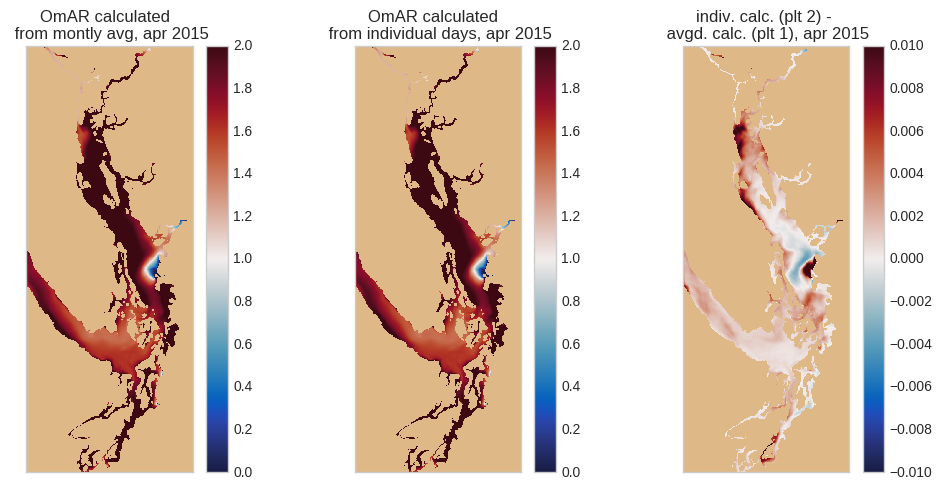

In [41]:
## plot code

sz = 1
fig = plt.figure(figsize=(12*sz,5.5*sz))
mn = 0 
mx = 2

ax1 = fig.add_subplot(1,3,1)
tplt = OmAR_meancalc
viz_tools.set_aspect(ax1)
mesh = ax1.pcolormesh(tplt, cmap=cm.cm.balance, vmin=mn, vmax=mx)
viz_tools.plot_land_mask(ax1, '/data/tjarniko/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea2.nc', color = 'burlywood')
cbar = plt.colorbar(mesh)
ax1.set_title('OmAR calculated  \n from montly avg, apr 2015')

ax2 = fig.add_subplot(1,3,2)
tplt = OmAR_indivcalc
viz_tools.set_aspect(ax2)
mesh = ax2.pcolormesh(tplt, cmap=cm.cm.balance, vmin=mn, vmax=mx)
viz_tools.plot_land_mask(ax2, '/data/tjarniko/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea2.nc', color = 'burlywood')
cbar = plt.colorbar(mesh)
ax2.set_title('OmAR calculated  \n from individual days, apr 2015')

ax3 = fig.add_subplot(1,3,3)
tplt = OmAR_indivcalc-OmAR_meancalc
viz_tools.set_aspect(ax3)
mesh = ax3.pcolormesh(tplt, cmap=cm.cm.balance, vmin=-0.01, vmax=0.01)
viz_tools.plot_land_mask(ax3, '/data/tjarniko/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea2.nc', color = 'burlywood')
cbar = plt.colorbar(mesh)
ax3.set_title('indiv. calc. (plt 2) - \n avgd. calc. (plt 1), apr 2015')

for ax in fig.axes:
    ax.set_xticks([])
    ax.set_yticks([])

